In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer, mean_absolute_percentage_error
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

In [2]:
df = pd.read_excel('Данные_для_курсовои_Классическое_МО.xlsx')

### Подготовка данных

In [3]:
# заполняем пропуски медианой
df = df.fillna(df.median())
print(df.shape)
total_nan = df.isnull().sum().sum()
print(f"Общее количество NaN: {total_nan}")

(1001, 214)
Общее количество NaN: 0


In [4]:
# устранение выбросов
Q1 = df['CC50, mM'].quantile(0.25)
Q3 = df['CC50, mM'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['CC50, mM'] >= lower_bound) & (df['CC50, mM'] <= upper_bound)]

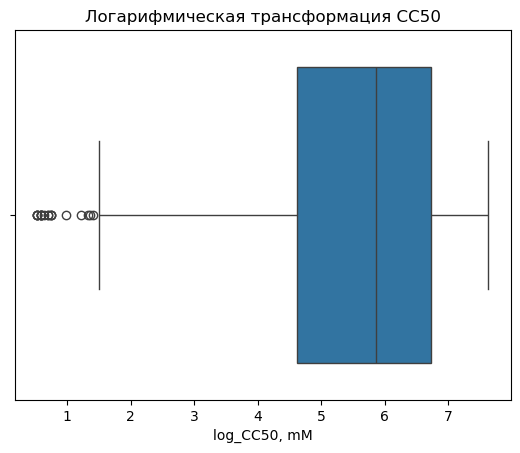

In [6]:
# Логарифмическая трансформация
df['log_CC50, mM'] = np.log(df['CC50, mM'] + 1)
sns.boxplot(x=df['log_CC50, mM'])
plt.title('Логарифмическая трансформация CC50')
plt.show()

In [11]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,"log_CC50, mM"
0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,...,0,0,0,0,0,0,0,3,0,5.173221
1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,...,0,0,0,0,0,0,0,3,0,1.856738
2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,...,0,0,0,0,0,0,0,3,0,5.088474
3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,...,0,0,0,0,0,0,0,4,0,4.690023
4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,...,0,0,0,0,0,0,0,0,0,4.943576


In [13]:
df = df.drop(df.columns[[0]], axis=1)

In [15]:
df = df.drop(df.columns[[0]], axis=1)

In [17]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,"log_CC50, mM"
0,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,384.652,340.300,384.350449,158,...,0,0,0,0,0,0,0,3,0,5.173221
1,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,388.684,340.300,388.381750,162,...,0,0,0,0,0,0,0,3,0,1.856738
2,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,446.808,388.344,446.458903,186,...,0,0,0,0,0,0,0,3,0,5.088474
3,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,398.679,352.311,398.366099,164,...,0,0,0,0,0,0,0,4,0,4.690023
4,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,466.713,424.377,466.334799,184,...,0,0,0,0,0,0,0,0,0,4.943576


In [19]:
# добавление фичей
df['Mol_properties_ratio'] = df['HeavyAtomMolWt'] / df['MolWt']
df['Electron_density'] = df['NumValenceElectrons'] / df['HeavyAtomCount']

df['Charge_imbalance'] = df['MaxPartialCharge'] - df['MinPartialCharge']
df['Abs_charge_range'] = df['MaxAbsPartialCharge'] - df['MinAbsPartialCharge']

df['Topological_complexity'] = df['Chi0'] + df['Chi1'] + df['Kappa1'] + df['Kappa2']
peoe_cols = [col for col in df.columns if 'PEOE_VSA' in col]
smr_cols = [col for col in df.columns if 'SMR_VSA' in col]

df['PEOE_VSA_total'] = df[peoe_cols].sum(axis=1)
df['SMR_VSA_total'] = df[smr_cols].sum(axis=1)

fr_cols = [col for col in df.columns if col.startswith('fr_')]
df['Functional_groups_total'] = df[fr_cols].sum(axis=1)

df['H_bond_groups'] = df['NumHAcceptors'] + df['NumHDonors']

df['Ring_complexity'] = (
    df['NumAromaticRings']
    + df['NumAliphaticRings']
    + df['NumSaturatedRings']
)

# удаление исходных фичей
columns_to_drop = peoe_cols + smr_cols + fr_cols + [
    'HeavyAtomMolWt', 'MolWt', 'NumValenceElectrons', 'HeavyAtomCount',
    'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
    'Chi0', 'Chi1', 'Kappa1', 'Kappa2',
    'NumHAcceptors', 'NumHDonors',
    'NumAromaticRings', 'NumAliphaticRings', 'NumSaturatedRings'
]

df.drop(columns=columns_to_drop, inplace=True)

In [21]:
# анализ мультиколинеарности и отбор фичей
target_vars = ['log_CC50, mM']
numeric_features = df.select_dtypes(include=np.number)

# анализ корреляционной матрицы между признаками
corr_matrix = numeric_features.corr()
# пары признаков с высокой корреляцией (>0.8 или <-0.8)
high_corr_pairs = [(col1, col2, corr_matrix.loc[col1, col2])
                   for col1 in corr_matrix.columns for col2 in corr_matrix.columns
                   if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.8]
print("Пары признаков с высокой корреляцией (>0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} и {pair[1]}: корреляция = {pair[2]:.2f}")

# VIF
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_features.columns

vif_data['VIF'] = [variance_inflation_factor(numeric_features.values, i)
                   for i in range(numeric_features.shape[1])]
print("\nПризнаки с высоким VIF (более 5):")
for index, row in vif_data.iterrows():
    if row['VIF'] > 5:
        print(f"{row['feature']}: VIF = {row['VIF']:.2f}")

# корреляция признаков с целевыми переменными
corr_with_targets = pd.DataFrame(index=numeric_features.columns)
for target in target_vars:
    corr_with_targets[target] = numeric_features.corrwith(df[target])

# удаление признаков
features_to_remove = set()
for col1, col2, corr_value in high_corr_pairs:
    # проверка наличия высокой корреляции с таргетом у каждого признака
    corr_col1_targets = corr_with_targets.loc[col1].abs()
    corr_col2_targets = corr_with_targets.loc[col2].abs()

    col1_has_target_corr = any(corr_col1_targets > 0.2)
    col2_has_target_corr = any(corr_col2_targets > 0.2)
    if not col1_has_target_corr and not col2_has_target_corr:
        features_to_remove.add(col2)
print("\nПризнаки для удаления из-за мультиколлинеарности без связи с таргетом:")
for feature in features_to_remove:
    print(feature)

# итоговый набор признаков после удаления
final_features = [col for col in numeric_features.columns if col not in features_to_remove]
print("\nОставшиеся признаки после удаления:")
print(final_features)

df_final = df[final_features]

Пары признаков с высокой корреляцией (>0.8):
MaxAbsEStateIndex и MaxEStateIndex: корреляция = 1.00
MaxEStateIndex и MaxAbsEStateIndex: корреляция = 1.00
SPS и FractionCSP3: корреляция = 0.85
ExactMolWt и BertzCT: корреляция = 0.90
ExactMolWt и Chi0n: корреляция = 0.93
ExactMolWt и Chi0v: корреляция = 0.95
ExactMolWt и Chi1n: корреляция = 0.90
ExactMolWt и Chi1v: корреляция = 0.92
ExactMolWt и LabuteASA: корреляция = 0.99
ExactMolWt и MolMR: корреляция = 0.96
ExactMolWt и Topological_complexity: корреляция = 0.98
ExactMolWt и PEOE_VSA_total: корреляция = 0.99
ExactMolWt и SMR_VSA_total: корреляция = 0.99
ExactMolWt и Functional_groups_total: корреляция = 0.81
FpDensityMorgan1 и FpDensityMorgan2: корреляция = 0.95
FpDensityMorgan1 и FpDensityMorgan3: корреляция = 0.80
FpDensityMorgan2 и FpDensityMorgan1: корреляция = 0.95
FpDensityMorgan2 и FpDensityMorgan3: корреляция = 0.94
FpDensityMorgan3 и FpDensityMorgan1: корреляция = 0.80
FpDensityMorgan3 и FpDensityMorgan2: корреляция = 0.94
BCU

In [23]:
df_final.head()

,MinAbsEStateIndex,MinEStateIndex,qed,NumRadicalElectrons,BCUT2D_MWLOW,BCUT2D_MRLOW,AvgIpc,BalabanJ,Ipc,Kappa3,...,VSA_EState9,NHOHCount,NumAliphaticHeterocycles,NumAromaticHeterocycles,NumRotatableBonds,NumSaturatedHeterocycles,MolLogP,"log_CC50, mM",Charge_imbalance,Abs_charge_range
0,0.387225,0.387225,0.417362,0,9.700470,0.193481,3.150503,1.164038,2.187750e+06,2.868737,...,0.000000,0,0,0,7,0,7.1212,5.173221,0.332369,0.254682
1,0.533868,0.533868,0.462473,0,9.689226,0.120322,3.150503,1.080362,2.187750e+06,3.027177,...,0.000000,2,0,0,9,0,6.1556,1.856738,0.326294,0.300521
2,0.543231,0.543231,0.260923,0,9.681293,-0.922902,3.214947,1.219066,8.610751e+06,3.470070,...,10.183618,0,0,0,9,0,7.1292,5.088474,0.420375,0.230772
3,0.390603,0.390603,0.377846,0,9.700497,0.193510,3.179270,1.120513,3.572142e+06,3.263848,...,0.000000,0,0,0,8,0,7.5113,4.690023,0.332369,0.254682
4,0.270476,0.270476,0.429038,0,9.700386,0.193687,3.337074,1.136678,1.053758e+08,3.345855,...,0.000000,0,0,0,4,0,9.1148,4.943576,0.320137,0.194342


In [25]:
# 20 самых важных признаков
X = df.drop(columns=['log_CC50, mM'])
y = df['log_CC50, mM']

importances = mutual_info_regression(X, y)

feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("20 самых важных признаков для СC50 по их значимости:")
print(feature_importances.head(20))

20 самых важных признаков для СC50 по их значимости:
ExactMolWt                1.116832
Topological_complexity    0.760262
SMR_VSA_total             0.747908
PEOE_VSA_total            0.747617
LabuteASA                 0.743992
Chi0v                     0.663551
MolMR                     0.614495
Chi0n                     0.610338
Chi1v                     0.599755
Charge_imbalance          0.592331
BCUT2D_CHGLO              0.583380
BCUT2D_MRLOW              0.578570
BCUT2D_LOGPLOW            0.572611
BertzCT                   0.567270
Chi1n                     0.552047
SPS                       0.548461
BCUT2D_MWLOW              0.543717
BCUT2D_CHGHI              0.542057
BCUT2D_MRHI               0.541876
Kappa3                    0.541013
dtype: float64


In [27]:
# удаление признаков с важностью менее 0.4
features_to_keep = feature_importances[feature_importances >= 0.4].index
X_drop = X[features_to_keep]

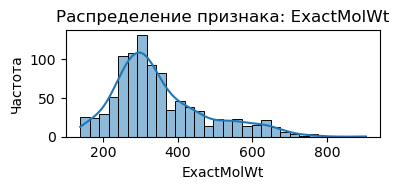

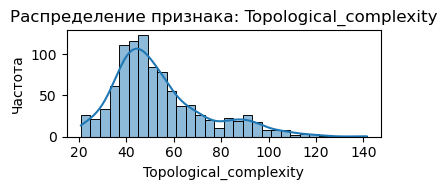

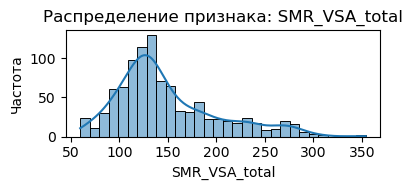

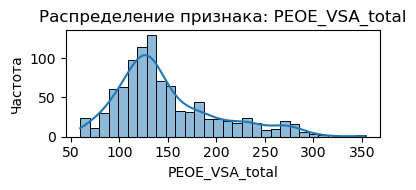

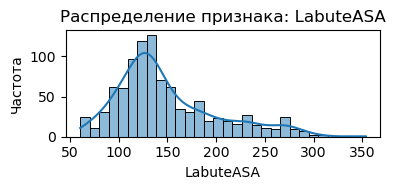

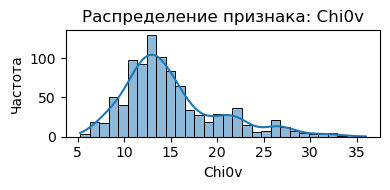

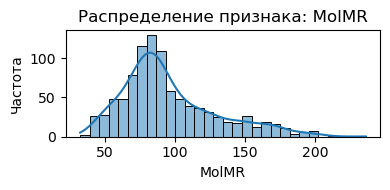

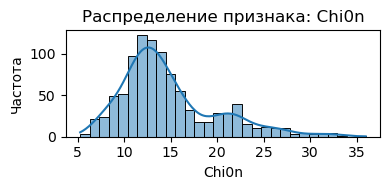

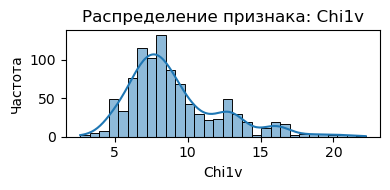

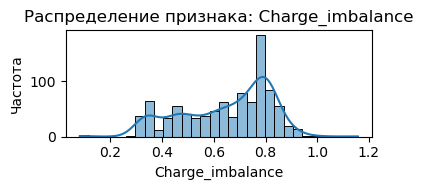

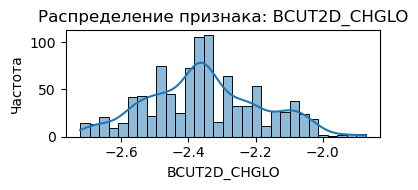

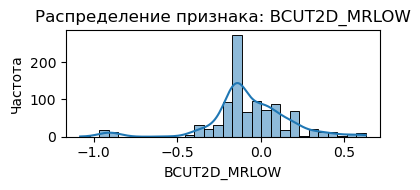

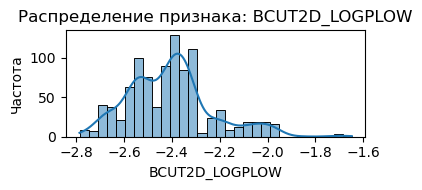

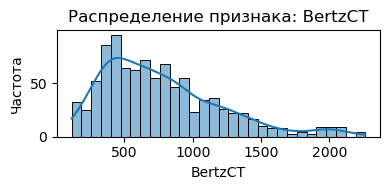

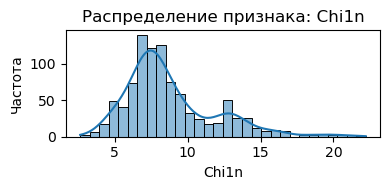

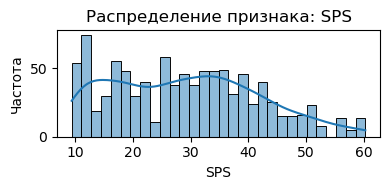

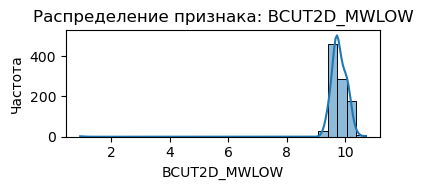

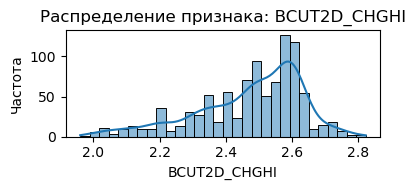

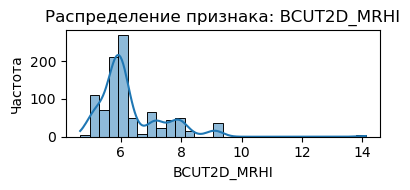

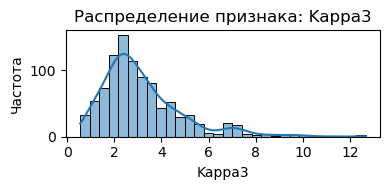

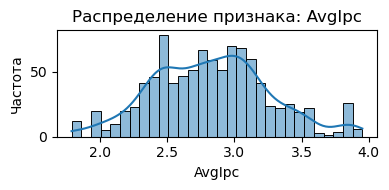

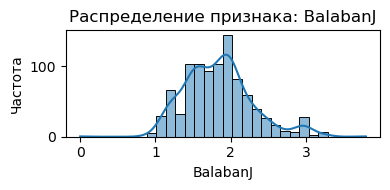

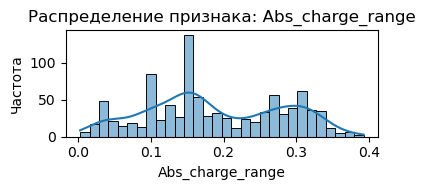

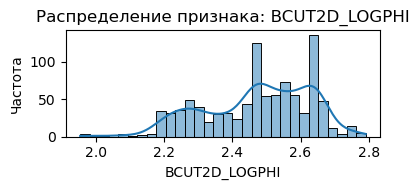

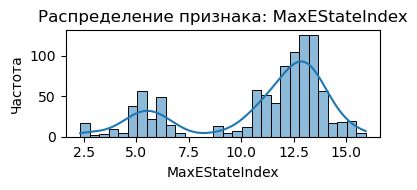

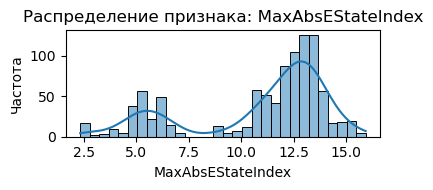

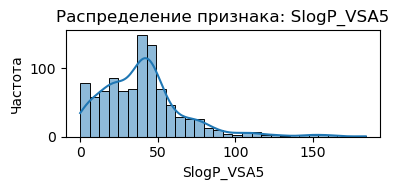

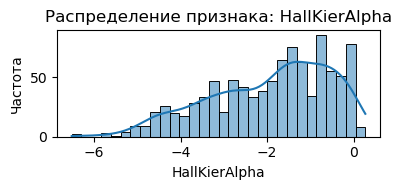

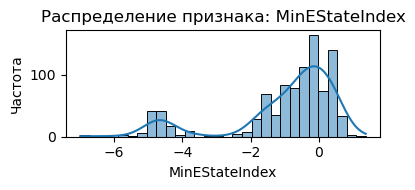

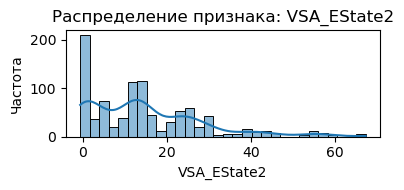

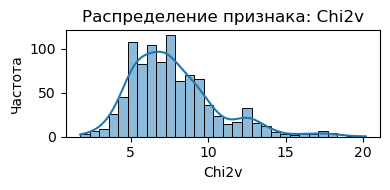

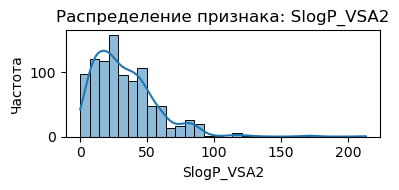

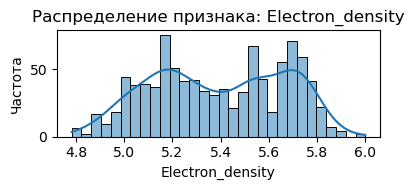

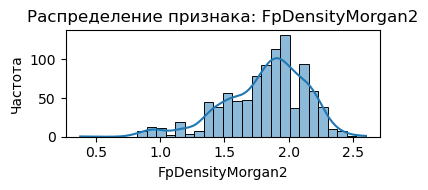

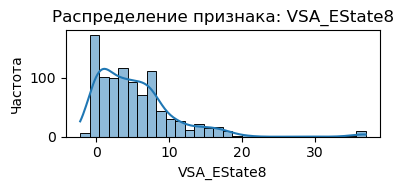

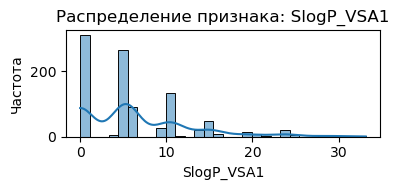

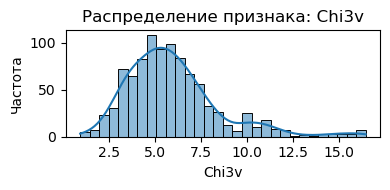

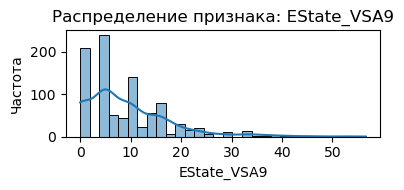

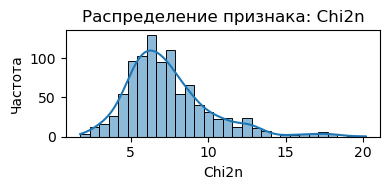

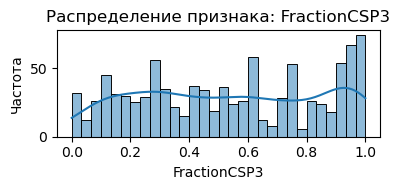

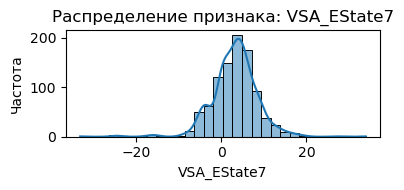

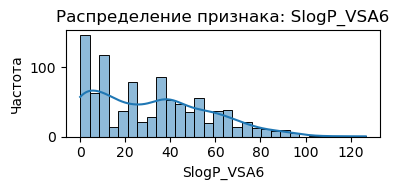

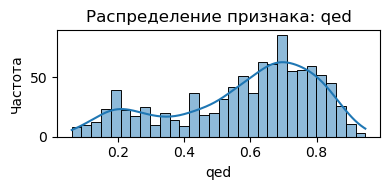

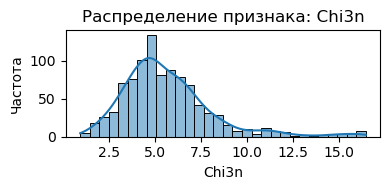

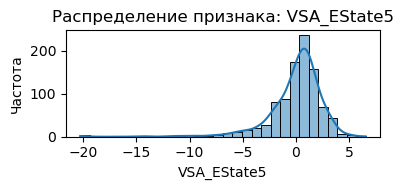

In [29]:
# построение графиков распределения оставшихся признаков
for feature in features_to_keep:
    plt.figure(figsize=(4, 2))
    sns.histplot(X_drop[feature], bins=30, kde=True)
    plt.title(f'Распределение признака: {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')
    plt.tight_layout() 
    plt.show()

In [31]:
# логарифмизация признаков
skewness = X_drop.skew()
print(skewness[skewness.abs() > 1])
features_to_log = skewness[skewness > 1].index

print("Признаки для логарифмирования СC50:", list(features_to_log))

for feature in features_to_log:
    min_value = X_drop[feature].min()
    if min_value <= 0:
        shift_value = abs(min_value) + 1e-9
        X_drop[feature] = np.log(X_drop[feature] + shift_value)
    else:
        X_drop[feature] = np.log(X_drop[feature])

ExactMolWt                 1.013320
Topological_complexity     1.072120
SMR_VSA_total              1.032208
PEOE_VSA_total             1.032208
LabuteASA                  1.033318
Chi0v                      1.109197
MolMR                      1.011557
Chi0n                      1.147489
Chi1v                      1.154385
BertzCT                    1.038477
Chi1n                      1.234558
BCUT2D_MWLOW             -14.346254
BCUT2D_MRHI                2.264857
Kappa3                     1.606381
MaxEStateIndex            -1.008167
MaxAbsEStateIndex         -1.008167
SlogP_VSA5                 1.410186
MinEStateIndex            -1.541483
VSA_EState2                1.171155
Chi2v                      1.106566
SlogP_VSA2                 1.764709
VSA_EState8                2.368108
SlogP_VSA1                 1.214363
Chi3v                      1.351499
EState_VSA9                1.589692
Chi2n                      1.277325
Chi3n                      1.530416
VSA_EState5               -2

In [33]:
# замена выбросов на границы интервала (IQR) для всех признаков
for feature in X_drop.columns:
    Q1 = X_drop[feature].quantile(0.25)
    Q3 = X_drop[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    before_values = X_drop[feature].copy()
    X_drop.loc[X_drop[feature] < lower_bound, feature] = lower_bound
    X_drop.loc[X_drop[feature] > upper_bound, feature] = upper_bound
    
    num_lower_replacements = (before_values < lower_bound).sum()
    num_upper_replacements = (before_values > upper_bound).sum()
    
    print(f"В признаке '{feature}': заменено {num_lower_replacements} значений ниже нижней границы и {num_upper_replacements} выше верхней границы.")

В признаке 'ExactMolWt': заменено 2 значений ниже нижней границы и 1 выше верхней границы.
В признаке 'Topological_complexity': заменено 15 значений ниже нижней границы и 5 выше верхней границы.
В признаке 'SMR_VSA_total': заменено 2 значений ниже нижней границы и 2 выше верхней границы.
В признаке 'PEOE_VSA_total': заменено 2 значений ниже нижней границы и 2 выше верхней границы.
В признаке 'LabuteASA': заменено 2 значений ниже нижней границы и 2 выше верхней границы.
В признаке 'Chi0v': заменено 3 значений ниже нижней границы и 11 выше верхней границы.
В признаке 'MolMR': заменено 3 значений ниже нижней границы и 2 выше верхней границы.
В признаке 'Chi0n': заменено 3 значений ниже нижней границы и 14 выше верхней границы.
В признаке 'Chi1v': заменено 6 значений ниже нижней границы и 11 выше верхней границы.
В признаке 'Charge_imbalance': заменено 0 значений ниже нижней границы и 0 выше верхней границы.
В признаке 'BCUT2D_CHGLO': заменено 0 значений ниже нижней границы и 1 выше верхне

In [35]:
X_drop.head()

,ExactMolWt,Topological_complexity,SMR_VSA_total,PEOE_VSA_total,LabuteASA,Chi0v,MolMR,Chi0n,Chi1v,Charge_imbalance,...,SlogP_VSA1,Chi3v,EState_VSA9,Chi2n,FractionCSP3,VSA_EState7,SlogP_VSA6,qed,Chi3n,VSA_EState5
0,5.951555,4.109077,5.157584,5.157584,5.156927,2.972177,4.800161,2.972177,2.501782,0.332369,...,-20.723266,2.369869,2.301065,2.489735,0.923077,13.258223,9.984809,0.417362,2.369869,1.764908
1,5.961989,4.123220,5.165090,5.165090,5.164439,2.985413,4.791711,2.985413,2.533360,0.326294,...,2.364017,2.440004,-0.173857,2.537542,1.000000,14.135381,0.000000,0.462473,2.440004,1.914377
2,6.101347,4.264452,5.306168,5.306168,5.304493,3.165015,4.930529,3.165015,2.656687,0.420375,...,-20.723266,2.595422,-0.173857,2.751826,1.000000,14.491619,0.000000,0.260923,2.595422,1.930720
3,5.987371,4.152558,5.193873,5.193873,5.192929,3.007736,4.837448,3.007736,2.541935,0.332369,...,-20.723266,2.392973,2.301065,2.518634,0.925926,14.695439,9.984809,0.377846,2.392973,1.769975
4,6.144904,4.276673,5.358588,5.358588,5.356207,3.118732,4.999493,3.118732,2.629644,0.320137,...,-20.723266,2.470933,2.301065,2.611077,0.575758,8.627311,58.515746,0.429038,2.470933,1.605178


In [37]:
# стандартизация
std = StandardScaler()
std.fit(X_drop)
X_std = std.transform(X_drop)
X_std_df = pd.DataFrame(X_std, columns=X_drop.columns)
print("Стандартизированные данные:")
X_std_df.head()

Стандартизированные данные:


,ExactMolWt,Topological_complexity,SMR_VSA_total,PEOE_VSA_total,LabuteASA,Chi0v,MolMR,Chi0n,Chi1v,Charge_imbalance,...,SlogP_VSA1,Chi3v,EState_VSA9,Chi2n,FractionCSP3,VSA_EState7,SlogP_VSA6,qed,Chi3n,VSA_EState5
0,0.420323,0.543255,0.636269,0.636269,0.634166,0.970242,0.879917,1.045079,1.077412,-1.827739,...,-1.452598,1.659154,0.510775,1.586662,1.260589,2.113293,-0.871177,-0.760902,1.788863,0.815368
1,0.451081,0.583874,0.658747,0.658747,0.656888,1.011021,0.855012,1.085923,1.173746,-1.862874,...,0.714475,1.834706,-1.669549,1.724619,1.509847,2.299335,-1.271094,-0.550962,1.963961,0.891590
2,0.861894,0.989473,1.081218,1.081218,1.080567,1.564360,1.264161,1.640163,1.549981,-1.318794,...,-1.452598,2.223722,-1.669549,2.342975,1.509847,2.374892,-1.271094,-1.488947,2.351971,0.899924
3,0.525906,0.668127,0.744940,0.744940,0.743076,1.079794,0.989815,1.154809,1.199905,-1.827739,...,-1.452598,1.716985,0.510775,1.670056,1.269821,2.418122,-0.871177,-0.944805,1.846545,0.817952
4,0.990294,1.024571,1.238193,1.238193,1.237009,1.421764,1.467424,1.497335,1.467479,-1.898480,...,-1.452598,1.912121,0.510775,1.936817,0.135153,1.131090,1.072613,-0.706561,2.041176,0.733913


In [39]:
# нормализация
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_drop)
X_normalized_df = pd.DataFrame(X_normalized, columns=X_drop.columns)
print("Нормализованные данные:")
X_normalized_df.head()

Нормализованные данные:


,ExactMolWt,Topological_complexity,SMR_VSA_total,PEOE_VSA_total,LabuteASA,Chi0v,MolMR,Chi0n,Chi1v,Charge_imbalance,...,SlogP_VSA1,Chi3v,EState_VSA9,Chi2n,FractionCSP3,VSA_EState7,SlogP_VSA6,qed,Chi3n,VSA_EState5
0,0.581576,0.614022,0.623829,0.623829,0.622934,0.710207,0.675115,0.726258,0.719374,0.232866,...,0.000000,0.830015,0.587869,0.810136,0.923077,0.930864,0.095509,0.403059,0.862394,0.658851
1,0.587684,0.622360,0.628277,0.628277,0.627437,0.718712,0.669972,0.734876,0.738549,0.227213,...,0.953053,0.864371,0.000000,0.837006,1.000000,0.967810,0.000000,0.453877,0.897913,0.674667
2,0.669270,0.705621,0.711869,0.711869,0.711391,0.834120,0.754452,0.851812,0.813438,0.314759,...,0.000000,0.940505,0.000000,0.957445,1.000000,0.982814,0.000000,0.226829,0.976622,0.676397
3,0.602544,0.639655,0.645332,0.645332,0.644515,0.733056,0.697806,0.749410,0.743756,0.232866,...,0.000000,0.841333,0.587869,0.826379,0.925926,0.991399,0.095509,0.358544,0.874095,0.659387
4,0.694769,0.712826,0.742929,0.742929,0.742391,0.804379,0.796421,0.821677,0.797016,0.221484,...,0.000000,0.879522,0.587869,0.878336,0.575758,0.735814,0.559726,0.416213,0.913577,0.641948


In [41]:
# разделение датасета на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X_drop, y, test_size=0.15, random_state=42)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

Train dataset size: (817, 45), (817,)
Train dataset size: (145, 45), (145,)


### Обучение моделей

In [62]:
models = {
    'Linear Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Ridge Regression': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', Ridge())
    ]),
    'KNN (KNeighborsRegressor)': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor(n_neighbors=5))
    ]),
    'Random Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', RandomForestRegressor(random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', GradientBoostingRegressor(random_state=42))
    ]),
    'HistGradientBoosting': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', HistGradientBoostingRegressor(random_state=42))
    ]),
    'AdaBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', AdaBoostRegressor(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', xgb.XGBRegressor(random_state=42, verbosity=0))
    ]),
    'LightGBM': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', lgb.LGBMRegressor(random_state=42))
    ]),
    'CatBoost Regressor': Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('model', CatBoostRegressor(
            random_seed=42,
            verbose=0 
        ))
    ])
}

# обучение и оценка моделей
results = {}
for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    
    print(f"{name}: MSE = {mse:.2f}, MAE = {mae:.2f}, R2 = {r2:.2f}")

# подбор гиперпараметров для лучшей модели
param_grid_cb = {
    'model__iterations': [100, 200],
    'model__depth': [4, 6],
    'model__learning_rate': [0.01, 0.1],
}

grid_search_cb = GridSearchCV(
    models['CatBoost Regressor'],
    param_grid_cb,
    cv=5,
    scoring='neg_mean_squared_error'
)

grid_search_cb.fit(X_train, y_train)

Linear Regression: MSE = 1.83, MAE = 1.07, R2 = 0.07
Ridge Regression: MSE = 1.82, MAE = 1.08, R2 = 0.08
KNN (KNeighborsRegressor): MSE = 1.22, MAE = 0.78, R2 = 0.38
Random Forest: MSE = 1.08, MAE = 0.75, R2 = 0.45
Gradient Boosting: MSE = 1.02, MAE = 0.76, R2 = 0.48
HistGradientBoosting: MSE = 1.12, MAE = 0.74, R2 = 0.43
AdaBoost: MSE = 1.63, MAE = 1.05, R2 = 0.17
XGBoost: MSE = 1.19, MAE = 0.76, R2 = 0.40
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10410
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 45
[LightGBM] [Info] Start training from score 5.453635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('model',
                                        <catboost.core.CatBoostRegressor object at 0x00000261562D03B0>)]),
             param_grid={'model__depth': [4, 6],
                         'model__iterations': [100, 200],
                         'model__learning_rate': [0.01, 0.1]},
             scoring='neg_mean_squared_error')

╒═══════════════════════════╤════════╤════════╤════════╕
│                           │    MSE │    MAE │     R2 │
╞═══════════════════════════╪════════╪════════╪════════╡
│ Linear Regression         │ 1.8290 │ 1.0728 │ 0.0722 │
├───────────────────────────┼────────┼────────┼────────┤
│ Ridge Regression          │ 1.8197 │ 1.0760 │ 0.0769 │
├───────────────────────────┼────────┼────────┼────────┤
│ KNN (KNeighborsRegressor) │ 1.2232 │ 0.7792 │ 0.3796 │
├───────────────────────────┼────────┼────────┼────────┤
│ Random Forest             │ 1.0783 │ 0.7510 │ 0.4530 │
├───────────────────────────┼────────┼────────┼────────┤
│ Gradient Boosting         │ 1.0176 │ 0.7634 │ 0.4838 │
├───────────────────────────┼────────┼────────┼────────┤
│ HistGradientBoosting      │ 1.1243 │ 0.7443 │ 0.4297 │
├───────────────────────────┼────────┼────────┼────────┤
│ AdaBoost                  │ 1.6283 │ 1.0483 │ 0.1741 │
├───────────────────────────┼────────┼────────┼────────┤
│ XGBoost                   │ 1

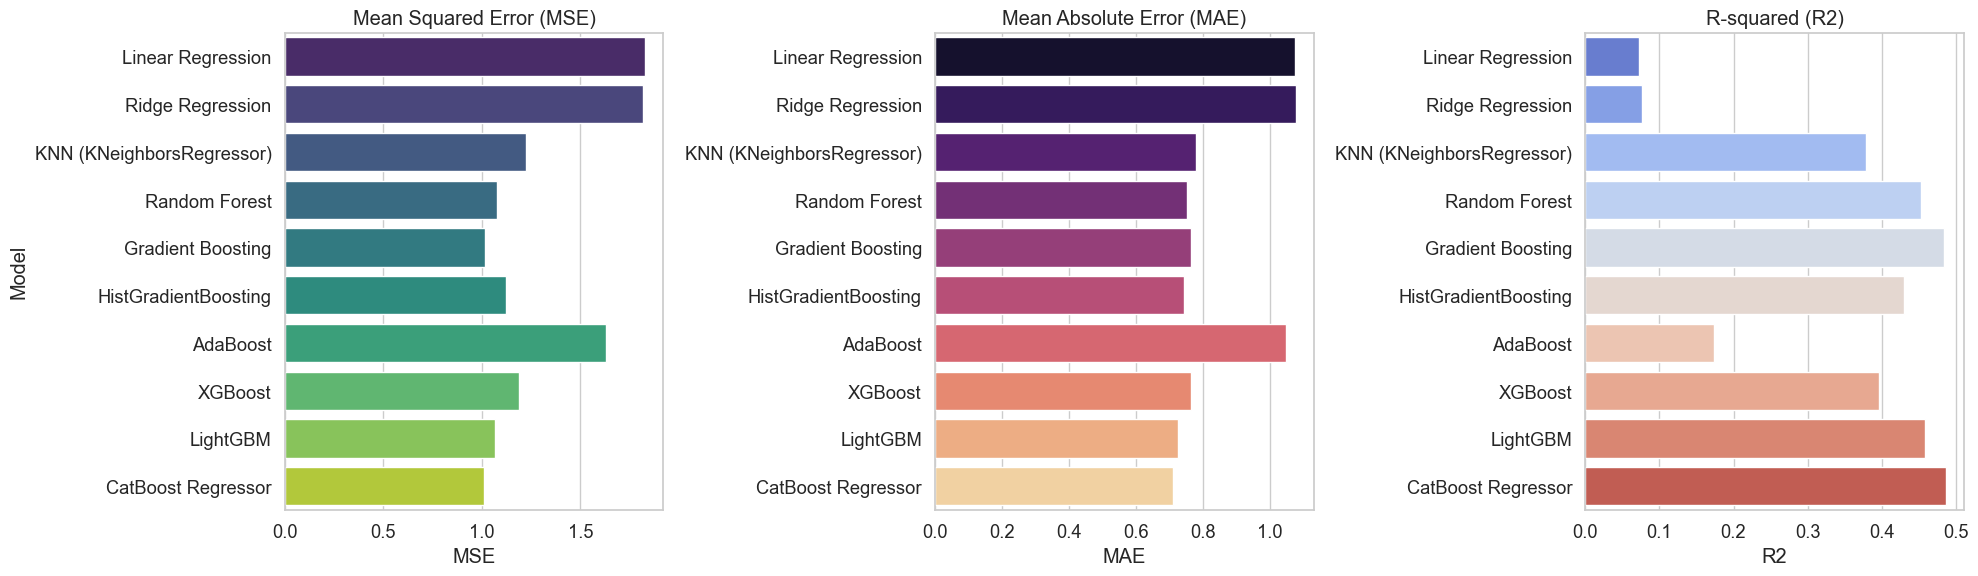

In [63]:
# визуализация результатов
results_df = pd.DataFrame(results).T  
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))


results_df = pd.DataFrame(results).T 
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.barplot(
    x='MSE',
    y=results_df.index,
    data=results_df,
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('MSE')
axes[0].set_ylabel('Model')

sns.barplot(
    x='MAE',
    y=results_df.index,
    data=results_df,
    ax=axes[1],
    palette='magma'
)
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('')

sns.barplot(
    x='R2',
    y=results_df.index,
    data=results_df,
    ax=axes[2],
    palette='coolwarm'
)
axes[2].set_title('R-squared (R2)')
axes[2].set_xlabel('R2')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

In [64]:
# вычисление MAPE
results_mape = []

for name, pipeline in models.items():
    y_pred = pipeline.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results_mape.append({'Модель': name, 'MAPE': mape})

results_df = pd.DataFrame(results_mape).sort_values(by='MAPE')

print(results_df.to_string(index=False))

                   Модель     MAPE
       CatBoost Regressor 0.154007
                 LightGBM 0.160966
                  XGBoost 0.163019
     HistGradientBoosting 0.163159
            Random Forest 0.164744
        Gradient Boosting 0.170870
KNN (KNeighborsRegressor) 0.177000
                 AdaBoost 0.224070
        Linear Regression 0.241683
         Ridge Regression 0.243297


### Побдор гиперпараметров

In [65]:
# подбор гиперпараметров
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {
        'model__alpha': [0.1, 1.0, 10.0]
    },
    'KNN (KNeighborsRegressor)': {
        'model__n_neighbors': [3, 5, 7],
        'model__weights': ['uniform', 'distance']
    },
    'Random Forest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1],
        'model__max_depth': [3, 5]
    },
    'HistGradientBoosting': {
        'model__max_iter': [100, 200],
        'model__max_depth': [None, 10]
    },
    'AdaBoost': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6],
        'model__learning_rate': [0.01, 0.1]
    },
    'LightGBM': {
        'model__n_estimators': [100, 200],
        'model__num_leaves': [31, 50],
        'model__learning_rate': [0.01, 0.1]
    },
    'CatBoost Regressor': {
        'model__iterations': [100, 200],
        'model__depth': [4, 6],
        'model__learning_rate': [0.01, 0.1]
    }
}

results = []

for name in models:
    print(f"\nОбучение и подбор гиперпараметров для {name}...")
    
    grid = GridSearchCV(
        models[name],
        param_grids.get(name, {}),
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_params = grid.best_params_
    

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "Best Params": best_params,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
     })

results_df = pd.DataFrame(results)
results_df['MSE'] = results_df['MSE'].round(3)
results_df['MAE'] = results_df['MAE'].round(3)
results_df['R2'] = results_df['R2'].round(3)

results_df['Best Params'] = results_df['Best Params'].apply(lambda x: str(x))

print("\nРезультаты моделей:")
print(tabulate(results_df.sort_values(by='R2'), headers='keys', tablefmt='fancy_grid', showindex=False))


Обучение и подбор гиперпараметров для Linear Regression...

Обучение и подбор гиперпараметров для Ridge Regression...

Обучение и подбор гиперпараметров для KNN (KNeighborsRegressor)...

Обучение и подбор гиперпараметров для Random Forest...

Обучение и подбор гиперпараметров для Gradient Boosting...

Обучение и подбор гиперпараметров для HistGradientBoosting...

Обучение и подбор гиперпараметров для AdaBoost...

Обучение и подбор гиперпараметров для XGBoost...

Обучение и подбор гиперпараметров для LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10410
[LightGBM] [Info] Number of data points in the train set: 817, number of used features: 45
[LightGBM] [Info] Start training from score 5.453635
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga